In [1]:
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import calc_qwk, get_dev_sample, fit_func, pred_func, remove_top_p_sample
from utils.general_utils import get_overall_score_range
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import polars as pl

/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## memo

-p1 80%
-p2 60%
-p3 70%
-p4 50%
-p5 60%
-p6 10%
-p7 30%
-p8 30%

# 分析用データフレームの作成

## BERTの場合

In [2]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
top_p_list = [0.8, 0.6, 0.7, 0.5, 0.6, 0.1, 0.3, 0.3]

prompt_arr = []
df_list = []
for test_prompt_id, top_p in zip(test_prompt_ids, top_p_list):
    
    train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
    # split test data into dev and test
    x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

    weights = remove_top_p_sample(np.load('outputs/Estimated_Data_Values/DVRL-word/' + f'estimated_data_value{test_prompt_id}.npy'), top_p=top_p, ascending=False)
    source_data_ids = np.concatenate([train_data['essay_id'], valid_data['essay_id']], axis=0)

    df = pl.DataFrame({'item_id': source_data_ids,
                       f'weights_for_prompt{test_prompt_id}': np.array([bool(w) for w in weights])
                       }).sort('item_id')
    df_list.append(df)

load data from data/cross_prompt_attributes/1/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1341, 653, 476, 446, 1447, 1548, 908, 452, 878, 916, 1244, 871, 945, 1368, 689, 746, 1645, 1509, 282, 1549, 151, 1299, 622, 1347, 915, 1570, 690, 305, 1577, 1359]
load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1192, 1298, 765, 955, 244, 995, 1140, 1215, 1710, 573, 988, 182, 310, 1195, 900, 519, 1398, 1515, 1622, 1632, 1000, 1055, 725, 502, 1006, 1276, 1198, 1629, 366, 1333]
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [332, 1005, 785, 396, 28, 960, 1302, 1434, 1387, 941, 1576, 1327, 914, 1620, 1673, 1422, 1529, 485, 530, 1035, 1573, 1278, 942, 101, 173, 592, 1571, 1227, 409, 1316]
load data from data/cross_prompt_attributes/4/...
Loading embedding from cache...
Selected 30 samples.
Selected sample

In [40]:
df_for_analysis = pl.read_csv("data/hand_crafted_v3.csv")
for i in range(len(df_list)):
    df_for_analysis = df_for_analysis.join(df_list[i], on='item_id', how='left')

In [57]:
f_col = {'mean_word': '平均単語数',
        'word_var': '単語長の分散',
        'mean_sent': '平均文数',
        'sent_var': '文数の分散',
        'ess_char_len': '文字数',
        'word_count': '単語数',
        'prep_comma': 'コンマと前置詞の数',
        'unique_word': 'ユニーク単語数',
        'clause_per_s': '文あたりの節の数',
        'mean_clause_l': '平均節の長さ',
        'max_clause_in_s': '文あたりの最大節の長さ',
        'spelling_err': 'スペルミスの数',
        'sent_ave_depth': '文の平均深さ',
        'ave_leaf_depth': '葉の平均深さ',
        'automated_readability': '可読性1',
        'linsear_write': '可読性2',
        'stop_prop': 'ストップワードの割合',
        'positive_sentence_prop': 'ポジティブな文の割合',
        'negative_sentence_prop': 'ネガティブな文の割合',
        'neutral_sentence_prop': 'ニュートラルな文の割合',
        'overall_positivity_score': '全体のポジティブ度',
        'overall_negativity_score': '全体のネガティブ度',
        #  ',',
        #  '.',
        #  'VB',
        #  'JJR',
        #  'WP',
        #  'PRP$',
        #  'VBN',
        #  'VBG',
        #  'IN',
        #  'CC',
        #  'JJS',
        #  'PRP',
        #  'MD',
        #  'WRB',
        #  'RB',
        #  'VBD',
        #  'RBR',
        #  'VBZ',
        #  'NNP',
        #  'POS',
        #  'WDT',
        #  'DT',
        #  'CD',
        #  'NN',
        #  'TO',
        #  'JJ',
        #  'VBP',
        #  'RP',
        #  'NNS',
}

In [42]:
# Normalize the weights columns to [0, 1] range
weight_columns = [col for col in df_for_analysis.columns if col in f_col]
for col in weight_columns:
    min_val = df_for_analysis[col].min()
    max_val = df_for_analysis[col].max()
    df_for_analysis = df_for_analysis.with_columns(
        ((pl.col(col) - min_val) / (max_val - min_val)).alias(col)
    )

# Get the score ranges for each prompt
score_ranges = get_overall_score_range()

# Normalize the score column based on prompt-specific min and max values
df_for_analysis = df_for_analysis.with_columns(
    pl.struct(['prompt_id', 'score']).map_elements(
        lambda x: (x['score'] - score_ranges[x['prompt_id']][0]) / (score_ranges[x['prompt_id']][1] - score_ranges[x['prompt_id']][0]),
        return_dtype=pl.Float64
    ).alias('normalized_score')
)

In [43]:
df_for_analysis.filter(pl.col('prompt_id') == 1).group_by('score').mean().sort('score')

score,item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,weights_for_prompt1,weights_for_prompt2,weights_for_prompt3,weights_for_prompt4,weights_for_prompt5,weights_for_prompt6,weights_for_prompt7,weights_for_prompt8,normalized_score
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.0,925.4,1.0,0.421892,0.151975,0.042766,0.000316,0.023477,0.024906,0.019672,0.043544,0.004902,0.02069,0.011765,0.013527,0.127083,0.181968,0.036654,0.14459,0.498785,0.723333,0.15,0.126667,0.471694,0.031093,0.019643,0.065702,0.044817,0.0,0.007341,0.019983,0.00351,0.005098,0.088176,0.036018,0.0,0.068227,0.015099,0.001587,0.024348,0.0,0.0,0.033658,0.024364,0.0,0.0,0.060562,0.0,0.1142,0.033084,0.096731,0.097981,0.00351,0.095152,NaN,1.0,0.0,0.7,1.0,0.8,1.0,0.0,0.0
3.0,22.0,1.0,0.514925,0.103695,0.088435,0.00019,0.051355,0.050752,0.043716,0.065823,0.029412,0.086207,0.058824,0.014493,0.270833,0.305368,0.068061,0.282787,0.558271,1.0,0.0,0.0,0.320045,0.0,0.0,0.033898,0.050847,0.0,0.0,0.067797,0.016949,0.016949,0.135593,0.050847,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.067797,0.0,0.0,0.118644,0.0,0.186441,0.033898,0.033898,0.050847,0.016949,0.101695,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.1
4.0,809.764706,1.0,0.425847,0.160223,0.073324,0.004565,0.082907,0.089617,0.070717,0.094118,0.021272,0.088911,0.062284,0.046888,0.173337,0.267789,0.061597,0.263941,0.466769,0.540616,0.193277,0.266106,0.58331,0.048035,0.019564,0.051078,0.057893,0.004836,0.001622,0.012523,0.007717,0.023538,0.102046,0.042284,0.000958,0.071427,0.030292,0.008548,0.038159,0.00633,0.001898,0.025266,0.021394,0.001425,0.002029,0.065848,0.001884,0.124751,0.023284,0.067503,0.062156,0.005861,0.091838,NaN,0.823529,0.0,0.352941,0.588235,0.647059,1.0,0.882353,0.2
5.0,950.529412,1.0,0.416426,0.151038,0.09981,0.00774,0.117371,0.126327,0.100289,0.122561,0.030033,0.116684,0.072664,0.055129,0.190089,0.274229,0.075272,0.282467,0.486284,0.56741,0.116947,0.315643,0.649675,0.00164,0.0142,0.043088,0.075887,0.006389,0.003364,0.010263,0.005603,0.018922,0.109004,0.046698,0.002597,0.065645,0.033323,0.005752,0.047582,0.004608,0.000835,0.019595,0.024469,0.003301,0.002619,0.062532,0.003572,0.124345,0.029896,0.062603,0.059755,0.005875,0.087325,NaN,1.0,0.0,0.294118,0.411765,0.764706,1.0,0.941176,0.3
6.0,852.672727,1.0,0.41221,0.151971,0.064932,0.006295,0.166786,0.180357,0.151664,0.166651,0.020657,0.127293,0.082353,0.074616,0.176398,0.2572,0.055526,0.2196,0.471108,0.572637,0.132376,0.294987,0.699671,0.005872,0.022731,0.051145,0.066967,0.004117,0.004189,0.016,0.006746,0.018874,0.104311,0.040872,0.0017,0.073271,0.027623,0.008167,0.048092,0.005587,0.001394,0.022713,0.033937,0.002932,0.002592,0.068567,0.002616,0.122013,0.02867,0.057029,0.057184,0.00664,0.076504,NaN,1.0,0.0,0.045455,0.0,0.7,1.0,1.0,0.4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8.0,904.05968,1.0,0.43097,0.162961,0.052382,0.004682,0.292691,0.311046,0.264109,0.250976,0.018409,0.118661,0.091617,0.116666,0.158375,0.240524,0.04565,0.178222,0.474044,0.504742,0.166066,0.329192,0.662957,0.014288,0.027621,0.05469,0.062413,0.005195,0.003958,0.01889,0.008695,0.020957,0.099818,0.036429,0.001761,0.071408,0.024889,0.008269,0.052294,0.008437,0.001843,0.023477,0.032277,0.001073,0.003336,0.070599,0.003072,0.125716,0.029692,0.055551,0.056328,0.005563,0.070997,NaN,0.727802,0.001456,0.193595,0.0,1.0,0.167394,1.0,

/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_72558/1083082816.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels([col for col in f_col.values()] + ['正規化済み得点'], rotation=90)
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_72558/1083082816.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels([col for col in f_col.values()] + ['正規化済み得点'], rotation=90)
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_72558/1083082816.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels([col for col in f_col.values()] + ['正規化済み得点'], rotation=90)
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_72558/1083082816.py:29: UserWarn

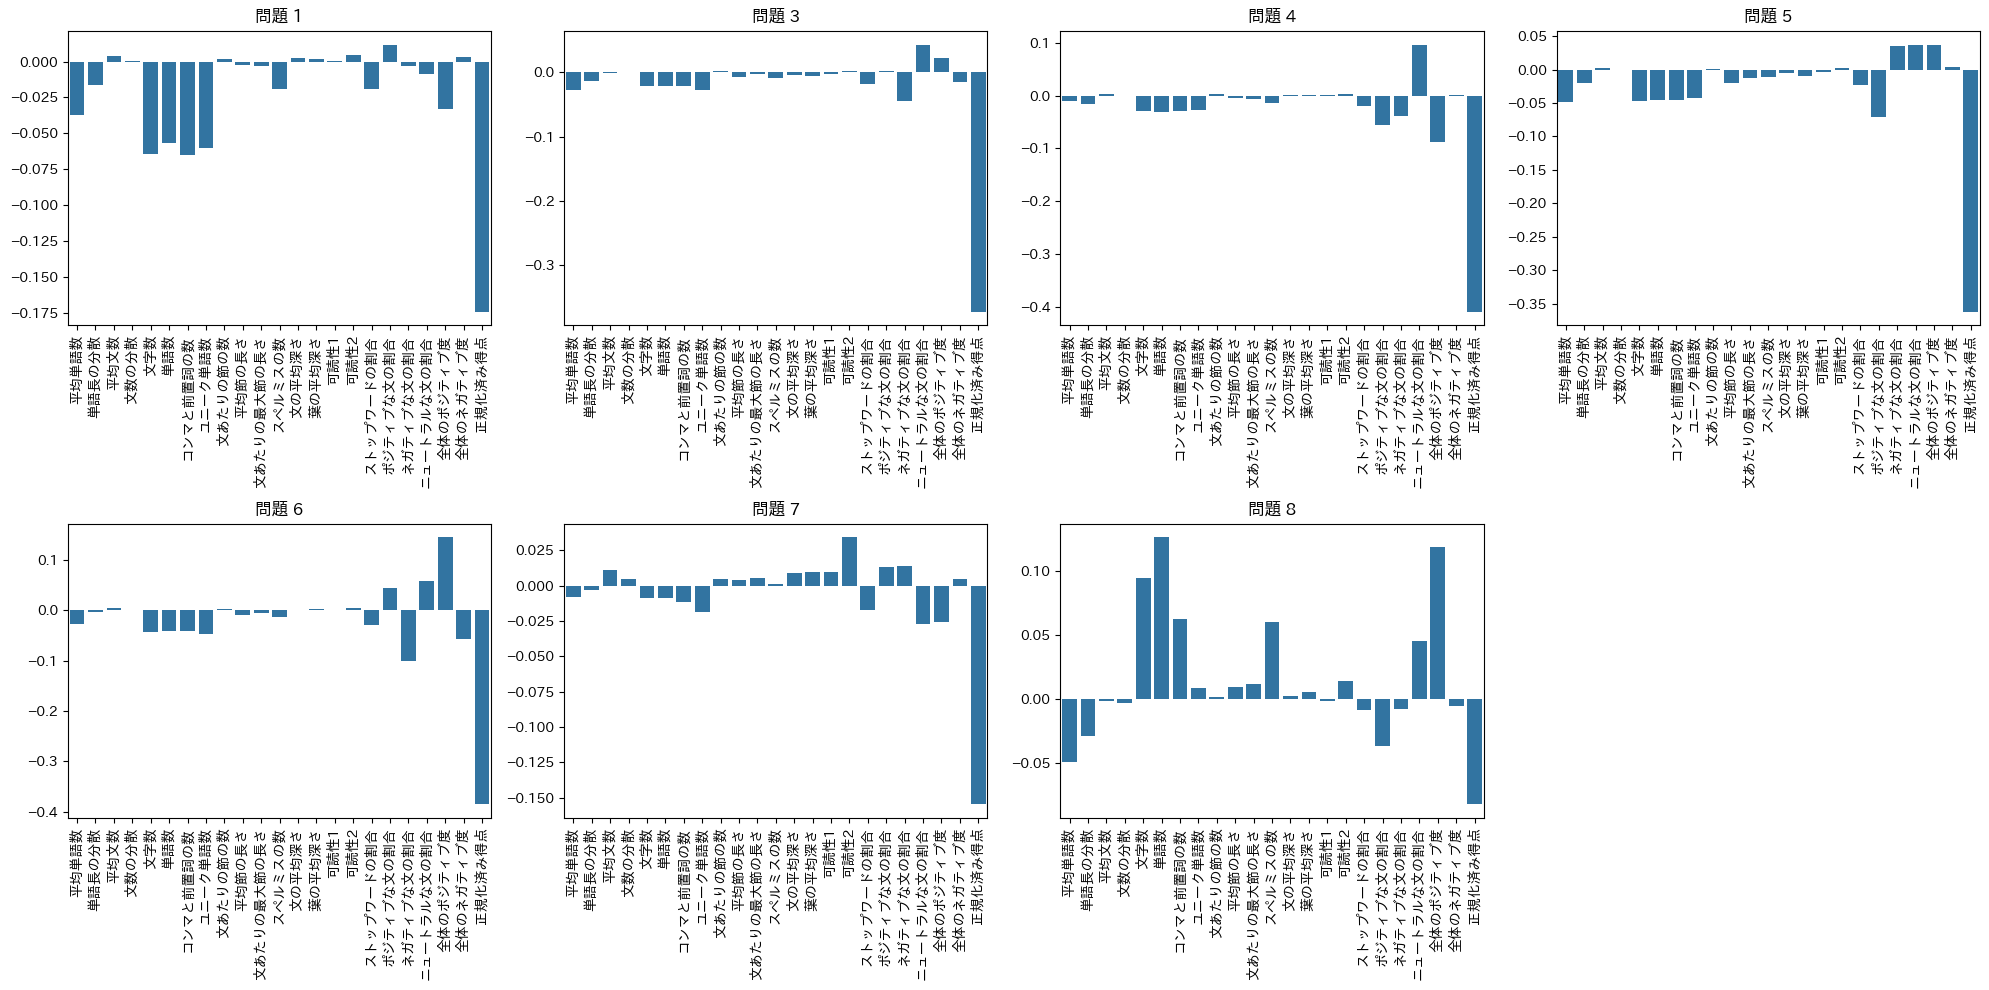

In [65]:
# Loop through prompt_ids 1-8, skipping prompt2
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# fig.suptitle('採択された小論文データとそうでない小論文データにおける各種特徴量の平均値の差', fontsize=20)

plot_index = 0
for prompt_id in range(1, 9):
    if prompt_id == 2:
        continue
    
    # Calculate means for True and False groups in weights_for_prompt2
    means = df_for_analysis.filter(
        pl.col('prompt_id') == prompt_id
    ).group_by(
        f'weights_for_prompt2'
    ).agg([pl.col(col).mean() for col in f_col.keys()]+[pl.col('normalized_score').mean()]
    ).sort(f'weights_for_prompt2', descending=True)

    # Calculate the difference between True and False groups
    diff = means.filter(pl.col(f'weights_for_prompt2') == True).select(pl.all().exclude(f'weights_for_prompt2')) - \
           means.filter(pl.col(f'weights_for_prompt2') == False).select(pl.all().exclude(f'weights_for_prompt2'))

    # Melt the difference DataFrame for easier plotting
    diff_melted = diff.melt(variable_name='feature', value_name='difference')

    # Create a bar plot to visualize the differences
    row = plot_index // 4
    col = plot_index % 4
    sns.barplot(data=diff_melted.to_pandas(), x='feature', y='difference', ax=axs[row, col])
    axs[row, col].set_xticklabels([col for col in f_col.values()] + ['正規化済み得点'], rotation=90)
    axs[row, col].set_title(f'問題 {prompt_id}')
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')
    
    plot_index += 1

# Remove the unused subplot
fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.savefig('outputs/figures/feature_difference.png')

In [9]:
df_for_analysis.filter(pl.col('weights_for_prompt3') == True).describe()

statistic,item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,score,weights_for_prompt1,weights_for_prompt2,weights_for_prompt3,weights_for_prompt4,weights_for_prompt5,weights_for_prompt6,weights_for_prompt7,weights_for_prompt8,normalized_score
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3214.0,3368.0,3376.0,2516.0,2321.0,2517.0,2964.0,3356.0,3376.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162.0,8.0,0.0,860.0,1055.0,859.0,412.0,20.0,0.0
"""mean""",12930.16173,5.0625,0.446321,0.164035,0.062619,0.003751,0.131298,0.134723,0.120808,0.151603,0.017636,0.097914,0.058545,0.049505,0.180412,0.259931,0.052318,0.207791,0.461973,0.491646,0.243025,0.26533,0.413222,0.064743,0.142168,0.07896,0.187472,0.03476,0.030283,0.137515,0.064847,0.133238,0.403312,0.205968,0.02727,0.127727,0.078001,0.096781,0.123291,0.203303,0.014281,0.168834,0.046492,0.014605,0.053186,0.214016,0.029463,0.290299,0.152383,0.192887,0.058437,0.050423,0.164781,4.757701,0.004667,0.092933,1.0,0.778617,0.831538,1.0,0.753036,0.491061,0.672897
"""std""",4065.132408,1.355134,0.11405,0.052983,0.032707,0.006369,0.110858,0.110032,0.114361,0.095725,0.018661,0.080744,0.041377,0.050245,0.054136,0.071491,0.024412,0.107132,0.090306,0.325614,0.284863,0.252796,0.360204,0.12256,0.124049,0.038334,0.108891,0.083508,0.068997,0.131333,0.059422,0.100847,0.111055,0.126191,0.063024,0.087426,0.072691,0.107669,0.063442,0.146813,0.045248,0.150541,0.043783,0.034987,0.083749,0.074656,0.050171,0.072685,0.097285,0.087593,0.070222,0.085922,0.106851,5.765692,null,null,null,null,null,null,null,null,0.251382
"""min""",16.0,1.0,0.047672,0.0,0.002915,0.0,0.00163,0.00188,0.0,0.005063,0.0,0.0,0.0,0.0,0.011905,0.059434,0.00861,0.02459,0.144737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
"""25%""",10261.0,4.0,0.380273,0.12535,0.044974,0.001015,0.064398,0.071429,0.04918,0.091139,0.005882,0.043103,0.058824,0.019324,0.145833,0.216301,0.03977,0.136612,0.401914,0.222222,0.0,0.0,0.0,0.0,0.035714,0.060724,0.110656,0.0,0.0,0.0,0.0,0.063291,0.336634,0.115385,0.0,0.060685,0.0,0.0,0.081731,0.092147,0.0,0.042017,0.01815,0.0,0.0,0.161074,0.0,0.241379,0.086207,0.136872,0.0,0.0,0.08,2.0,null,null,null,null,null,null,null,null,0.5
"""50%""",12976.0,5.0,0.457359,0.165095,0.056122,0.002103,0.104341,0.109023,0.092896,0.131646,0.014706,0.091954,0.058824,0.038647,0.176282,0.254279,0.04961,0.190164,0.465103,0.5,0.142857,0.2,0.439642,0.0,0.125523,0.074598,0.18,0.0,0.0,0.117284,0.057471,0.121212,0.404255,0.196629,0.0,0.113636,0.06875,0.068783,0.119967,0.184615,0.0,0.136,0.040041,0.0,0.0,0.213018,0.0,0.285714,0.142857,0.192913,0.036199,0.0,0.160804,3.0,null,null,null,null,null,null,null,null,0.666667
"""75%""",15737.0,6.0,0.529634,0.20

In [10]:
df_for_analysis.filter(pl.col('weights_for_prompt3') == False).describe()

statistic,item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,score,weights_for_prompt1,weights_for_prompt2,weights_for_prompt3,weights_for_prompt4,weights_for_prompt5,weights_for_prompt6,weights_for_prompt7,weights_for_prompt8,normalized_score
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,6253.0,6084.0,7874.0,6962.0,7124.0,6933.0,6717.0,7171.0,7874.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1621.0,1790.0,0.0,912.0,750.0,941.0,1157.0,703.0,0.0
"""mean""",9924.070993,4.059944,0.413554,0.157488,0.062311,0.005833,0.242772,0.261687,0.224875,0.220054,0.019588,0.110937,0.079263,0.091492,0.172151,0.251805,0.050884,0.197769,0.449871,0.431988,0.249962,0.318051,0.511825,0.045464,0.160579,0.080793,0.238559,0.045448,0.047363,0.116228,0.065083,0.131679,0.392946,0.233844,0.030098,0.153724,0.105192,0.080274,0.142023,0.158753,0.017488,0.130165,0.044316,0.015462,0.056435,0.177023,0.03073,0.257083,0.155205,0.19295,0.130981,0.065909,0.203782,8.760351,0.343835,0.619822,0.0,0.390118,0.163953,0.847252,0.677832,0.826802,0.533649
"""std""",7261.113452,2.466483,0.102199,0.047202,0.044739,0.023057,0.163044,0.177576,0.165895,0.115074,0.024061,0.06976,0.050945,0.07921,0.053576,0.06587,0.035653,0.108522,0.080549,0.25071,0.225932,0.219623,0.392013,0.098039,0.116915,0.03403,0.104816,0.074259,0.064799,0.098521,0.053348,0.089233,0.097426,0.114084,0.056772,0.077821,0.076299,0.081887,0.059795,0.157227,0.042312,0.108874,0.051173,0.039151,0.071691,0.068134,0.042637,0.068058,0.077321,0.071875,0.099657,0.07216,0.121108,10.355124,null,null,null,null,null,null,null,null,0.202622
"""min""",1.0,1.0,0.008529,0.015729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3326.0,2.0,0.347986,0.124942,0.043273,0.001555,0.116976,0.12688,0.098361,0.136709,0.008403,0.074713,0.058824,0.038647,0.138889,0.209434,0.03731,0.131148,0.397284,0.25,0.058824,0.166667,0.0,0.0,0.069231,0.063106,0.168307,0.0,0.0,0.041059,0.026455,0.072464,0.334913,0.16092,0.0,0.098502,0.048299,0.024833,0.104938,0.030275,0.0,0.054054,0.012657,0.0,0.0,0.130293,0.0,0.213115,0.104712,0.149775,0.044444,0.0,0.108108,2.0,null,null,null,null,null,null,null,null,0.4
"""50%""",9904.0,4.0,0.4182,0.154529,0.054082,0.002683,0.198696,0.216165,0.180328,0.2,0.01518,0.107759,0.058824,0.072464,0.166667,0.244844,0.04551,0.180328,0.44809,0.4,0.2,0.3,0.668373,0.0,0.14876,0.077814,0.234597,0.0,0.025641,0.098519,0.05618,0.119904,0.393443,0.229508,0.0,0.151554,0.095861,0.061033,0.141079,0.099435,0.0,0.108696,0.031851,0.0,0.034483,0.164835,0.01816,0.250765,0.147849,0.192197,0.122449,0.053391,0.195556,4.0,null,null,null,null,null,null,null,null,0.6
"""75%""",16426.0

## （実験１）問題ごとの採択比率の分析

load data from data/cross_prompt_attributes/1/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1065, 653, 689, 446, 939, 1548, 1244, 452, 1447, 916, 945, 871, 878, 1368, 476, 746, 1645, 1299, 1509, 282, 151, 1549, 622, 1347, 915, 1570, 690, 1348, 305, 1359]
source_data_prompts len: 11193
target_data_prompts len: 1753
load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [363, 1298, 1140, 955, 765, 995, 244, 1215, 988, 573, 1398, 182, 900, 1195, 310, 519, 1710, 1515, 1622, 1632, 725, 1055, 502, 1276, 1006, 1000, 1198, 1333, 366, 1526]
source_data_prompts len: 11178
target_data_prompts len: 1768
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1488, 785, 1005, 396, 28, 960, 1302, 1434, 1387, 941, 1576, 1327, 914, 1620, 1673, 1422, 1529, 485, 530, 1278, 1573, 101, 942, 1035, 173, 592, 1571, 1227, 409, 13

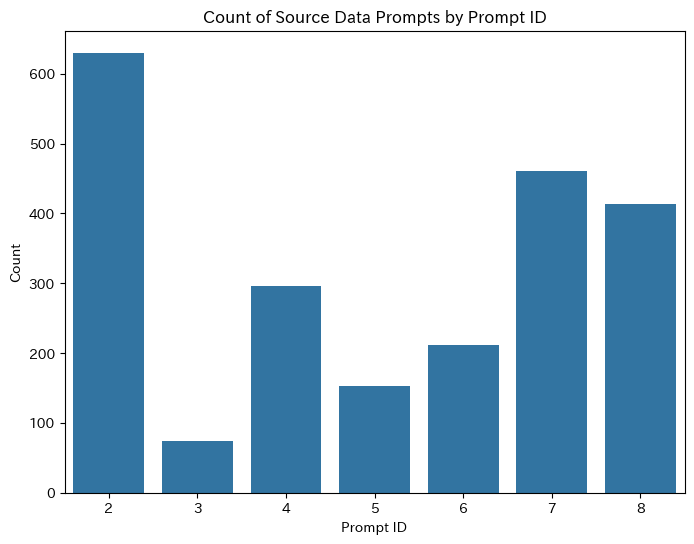

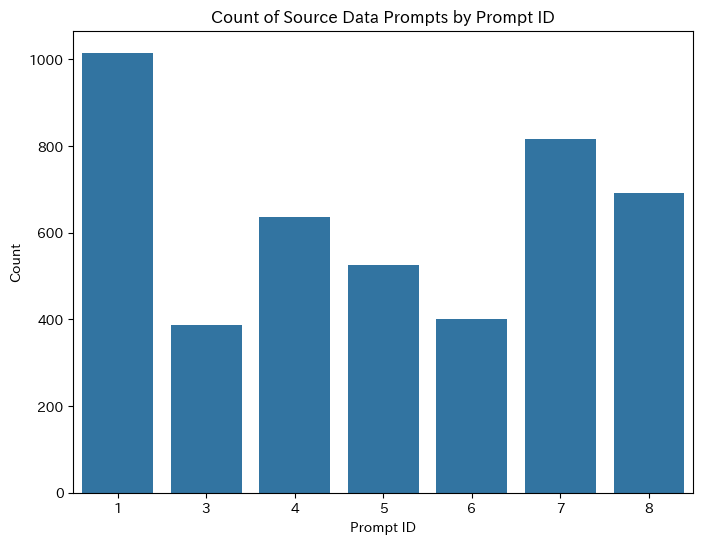

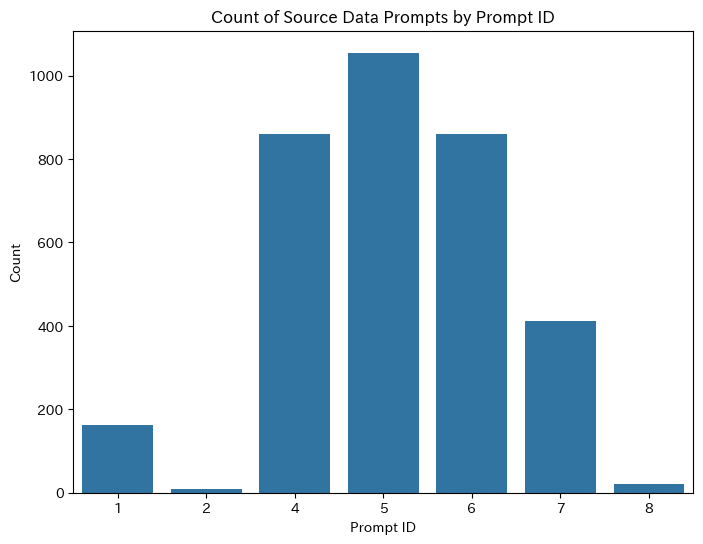

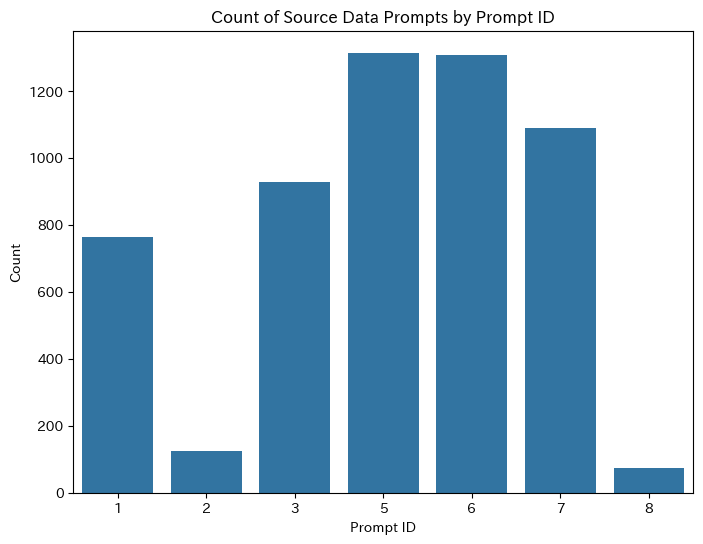

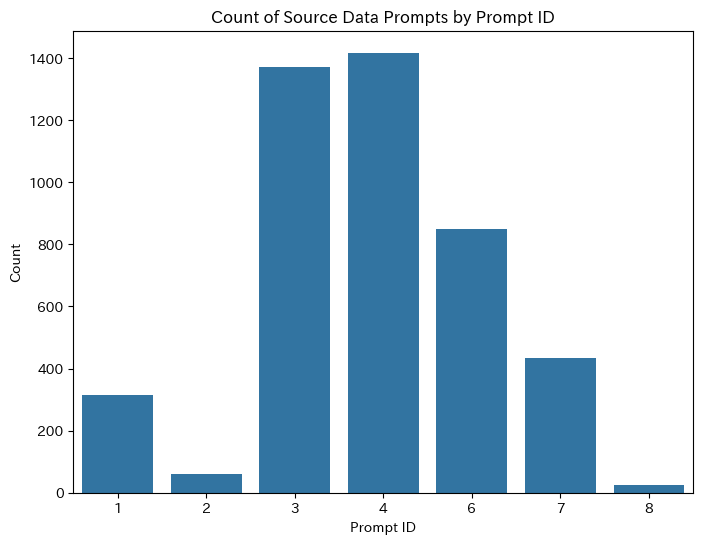

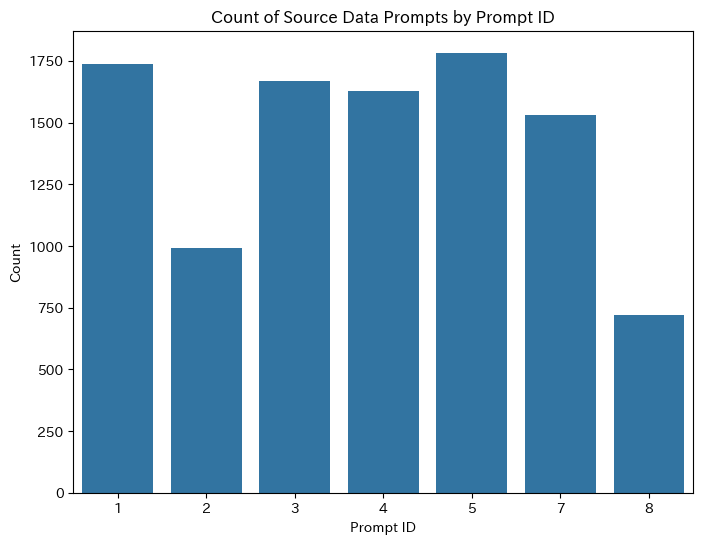

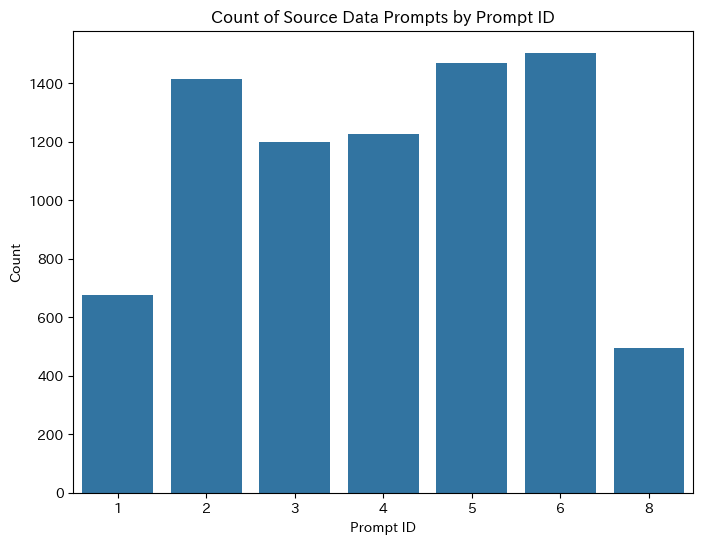

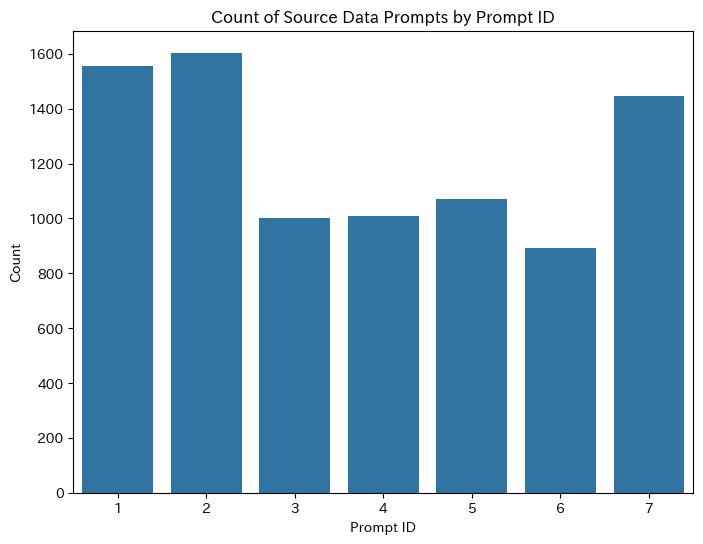

In [3]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
top_p_list = [0.8, 0.6, 0.7, 0.5, 0.6, 0.1, 0.3, 0.3]

prompt_arr = []
num_prompts = []
for test_prompt_id, top_p in zip(test_prompt_ids, top_p_list):
    train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
    # split test data into dev and test
    x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

    weights = remove_top_p_sample(np.load('outputs/Estimated_Data_Values/DVRL-word/' + f'estimated_data_value{test_prompt_id}.npy'), top_p=top_p, ascending=False)

    source_data_prompts = np.concatenate([train_data['essay_set'], valid_data['essay_set']], axis=0)
    target_data_prompts = np.array(test_data['essay_set'])[test_idx]

    print('source_data_prompts len:', len(source_data_prompts))
    print('target_data_prompts len:', len(target_data_prompts))
    num_prompts.append(len(target_data_prompts))

    source_data_prompts = source_data_prompts[weights == 1]

    # Count the occurrences of each unique value in source_data_prompts
    unique, counts = np.unique(source_data_prompts, return_counts=True)
    # Plot the counts
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique, y=counts)
    plt.xlabel('Prompt ID')
    plt.ylabel('Count')
    plt.title('Count of Source Data Prompts by Prompt ID')
    # plt.savefig('outputs/figures/' + f'count_of_source_data_prompts_by_prompt_id{test_prompt_id}.png')

    count_list = counts.tolist()
    count_list.insert(test_prompt_id-1, 0)
    prompt_arr.append(count_list)


In [4]:
num_prompts = np.array(num_prompts).reshape(1, -1)
num_prompts

array([[1753, 1768, 1696, 1742, 1775, 1770, 1539,  693]])

In [5]:
prompt_arr = np.array(prompt_arr, dtype=float)
prompt_arr

array([[   0.,  630.,   74.,  296.,  153.,  212.,  461.,  413.],
       [1015.,    0.,  388.,  635.,  525.,  401.,  817.,  691.],
       [ 162.,    8.,    0.,  860., 1055.,  859.,  412.,   20.],
       [ 765.,  124.,  927.,    0., 1314., 1308., 1090.,   74.],
       [ 315.,   59., 1371., 1417.,    0.,  848.,  435.,   24.],
       [1738.,  993., 1668., 1629., 1783.,    0., 1529.,  719.],
       [ 677., 1415., 1200., 1227., 1469., 1504.,    0.,  493.],
       [1557., 1604., 1001., 1008., 1071.,  892., 1445.,    0.]])

In [14]:
# 各問題の採択数を正規化
normalized_arr = prompt_arr / num_prompts
normalized_arr

array([[0.        , 0.35633484, 0.04363208, 0.16991963, 0.08619718,
        0.11977401, 0.29954516, 0.5959596 ],
       [0.57900742, 0.        , 0.22877358, 0.36452354, 0.29577465,
        0.22655367, 0.5308642 , 0.997114  ],
       [0.09241301, 0.00452489, 0.        , 0.49368542, 0.5943662 ,
        0.48531073, 0.2677063 , 0.02886003],
       [0.43639475, 0.07013575, 0.54658019, 0.        , 0.74028169,
        0.73898305, 0.70825211, 0.10678211],
       [0.17969196, 0.03337104, 0.80837264, 0.81343284, 0.        ,
        0.47909605, 0.28265107, 0.03463203],
       [0.99144324, 0.56165158, 0.98349057, 0.93513203, 1.00450704,
        0.        , 0.99350227, 1.03751804],
       [0.38619509, 0.80033937, 0.70754717, 0.7043628 , 0.82760563,
        0.84971751, 0.        , 0.71139971],
       [0.88819167, 0.90723982, 0.59021226, 0.57864524, 0.60338028,
        0.5039548 , 0.93892138, 0.        ]])

In [10]:

conmat = normalized_arr / normalized_arr.sum(axis=1).reshape(-1, 1)
conmat

array([[0.        , 0.21320021, 0.02610569, 0.10166534, 0.051573  ,
        0.0716625 , 0.17922214, 0.35657112],
       [0.17967028, 0.        , 0.07099013, 0.11311434, 0.09178106,
        0.07030128, 0.16473108, 0.30941183],
       [0.04698489, 0.00230056, 0.        , 0.25100097, 0.30218938,
        0.24674309, 0.13610801, 0.0146731 ],
       [0.1303679 , 0.02095224, 0.16328452, 0.        , 0.22115061,
        0.22076266, 0.21158214, 0.03189992],
       [0.06829154, 0.01268259, 0.30722028, 0.3091434 , 0.        ,
        0.18207942, 0.10742093, 0.01316183],
       [0.15235991, 0.08631173, 0.15113779, 0.14370629, 0.15436749,
        0.        , 0.15267633, 0.15944045],
       [0.07743777, 0.16047975, 0.14187356, 0.14123505, 0.16594704,
        0.17038079, 0.        , 0.14264605],
       [0.17726447, 0.18106608, 0.11779401, 0.11548548, 0.12042208,
        0.10057883, 0.18738906, 0.        ]])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5'),
  Text(0, 5.5, '6'),
  Text(0, 6.5, '7'),
  Text(0, 7.5, '8')])

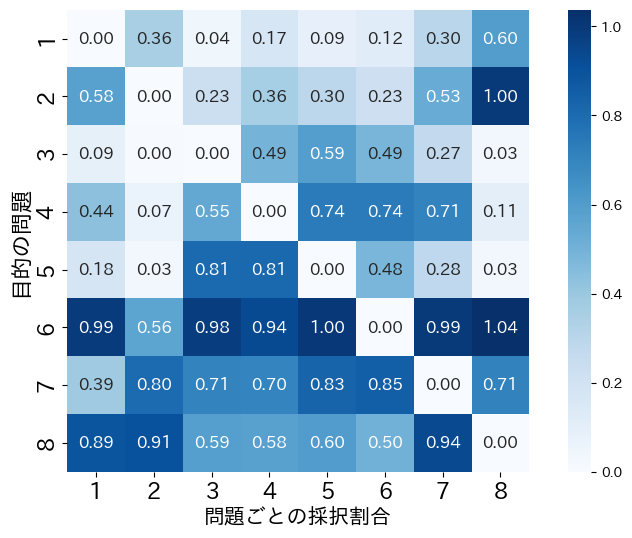

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    normalized_arr,
    # conmat,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    yticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    annot_kws={'size': 12}
)
plt.xlabel('問題ごとの採択割合', fontsize=15)
plt.ylabel('目的の問題', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('outputs/figures/' + f'prompt_usage_rate.png')

## （実験２）回答文の特徴分布の差を問題ごとに計算する

In [8]:
import numpy as np

def gaussian_kernel(x1, x2, sigma=1.0):
    """
    Compute the Gaussian kernel between two vectors.
    
    Args:
        x1: First vector.
        x2: Second vector.
        sigma: Bandwidth of the Gaussian kernel.
        
    Returns:
        The Gaussian kernel between x1 and x2.
    """
    diff = np.linalg.norm(x1 - x2)
    return np.exp(-diff ** 2 / (2 * sigma ** 2))

def squared_MMD(
    source: np.ndarray,
    target: np.ndarray,
    kernel: callable = gaussian_kernel
) -> float:
    """
    Compute the squared maximum mean discrepancy (MMD) between source and target.
    
    Args:
        source: Source data.
        target: Target data.
        kernel: Kernel function.
        
    Returns:
        The squared MMD between source and target.
    """
    m = len(source)
    n = len(target)
    
    mmd_ss = 0.0
    mmd_tt = 0.0
    mmd_st = 0.0

    for i in range(m):
        for j in range(m):
            mmd_ss += kernel(source[i], source[j])
    mmd_ss *= 1.0 / m ** 2
    
    for i in range(n):
        for j in range(n):
            mmd_tt += kernel(target[i], target[j])
    mmd_tt *= 1.0 / n ** 2
    
    for i in range(m):
        for j in range(n):
            mmd_st -= kernel(source[i], target[j])
    mmd_st *= 2.0 / (m * n)
    
    return mmd_ss + mmd_tt + mmd_st

In [19]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
source_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]

mmd_matrix = np.zeros((8, 8))
for source_prompt_id in source_prompt_ids:
    for test_prompt_id in test_prompt_ids:
        if test_prompt_id == source_prompt_id:
            continue
        train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
        # split test data into dev and test
        x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

        source_data_prompts = np.concatenate([train_data['essay_set'], valid_data['essay_set']], axis=0)

        source_data_rep = np.concatenate([train_data['essay'], valid_data['essay']], axis=0)[source_data_prompts == source_prompt_id]
        target_data_rep = np.array(test_data['essay'])

        mmd = squared_MMD(source_data_rep, target_data_rep)
        mmd_matrix[test_prompt_id-1, source_prompt_id-1] = mmd
        print(f'MMD between prompt {source_prompt_id} and prompt {test_prompt_id}: {mmd}')

load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [341, 1298, 765, 955, 244, 995, 900, 1215, 1398, 573, 988, 182, 1140, 1195, 310, 519, 1710, 1515, 1622, 1632, 725, 1055, 1629, 1000, 1006, 1276, 1198, 502, 366, 1333]
MMD between prompt 1 and prompt 2: 0.023901703138679675
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1425, 785, 1005, 396, 28, 960, 1434, 1302, 941, 1387, 1327, 914, 1620, 1576, 485, 1673, 1422, 1529, 1035, 1573, 1278, 942, 101, 530, 592, 173, 1227, 1571, 1316, 409]
MMD between prompt 1 and prompt 3: 0.586691539971
load data from data/cross_prompt_attributes/4/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [807, 129, 409, 1412, 646, 926, 40, 454, 897, 1707, 334, 285, 191, 705, 760, 49, 900, 1432, 1240, 1393, 1063, 452, 918, 1415, 908, 997, 1145, 236, 1305, 1380]
MMD between promp

In [20]:
mmd_matrix

array([[0.        , 0.0239017 , 0.58669154, 0.59994466, 0.5162282 ,
        0.47878866, 0.31690769, 0.20299087],
       [0.0239017 , 0.        , 0.56406132, 0.57760293, 0.49461276,
        0.4536904 , 0.31431072, 0.15131053],
       [0.58669154, 0.56406132, 0.        , 0.01357968, 0.01726762,
        0.08975505, 0.09627567, 0.81768557],
       [0.59994466, 0.57760292, 0.01357968, 0.        , 0.04903616,
        0.14217847, 0.13766069, 0.81755518],
       [0.51622819, 0.49461275, 0.01726762, 0.04903615, 0.        ,
        0.04235486, 0.05012056, 0.77072052],
       [0.47878866, 0.45369039, 0.08975505, 0.14217847, 0.04235487,
        0.        , 0.06521653, 0.75436992],
       [0.31690769, 0.31431072, 0.09627567, 0.13766069, 0.05012056,
        0.06521653, 0.        , 0.60719368],
       [0.20299087, 0.15131053, 0.81768558, 0.81755518, 0.77072053,
        0.75436993, 0.60719368, 0.        ]])

In [21]:
np.save('outputs/figures/mmd_matrix.npy', mmd_matrix)

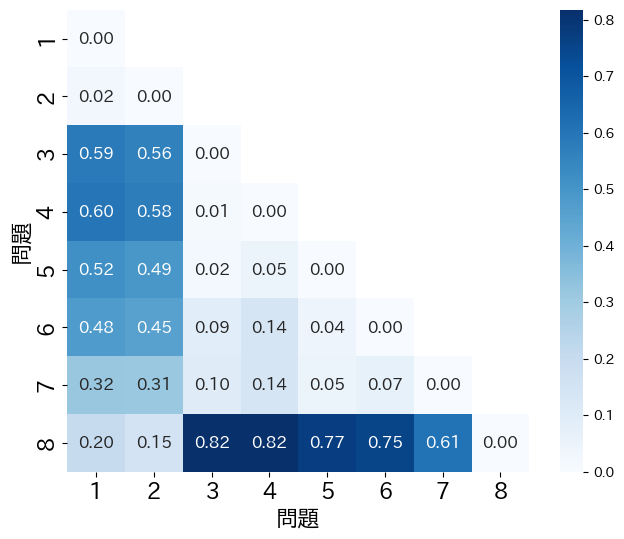

In [22]:
plt.figure(figsize=(8, 6))
mask = np.tril(np.ones((8, 8), dtype=bool), 0)
sns.heatmap(
    mmd_matrix,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    yticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    mask=~mask,
    annot_kws={'fontsize': 12}
)
plt.xlabel('問題', fontsize=16)
plt.ylabel('問題', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('MMD between Source and Target Prompts')
plt.savefig('outputs/figures/mmd_matrix.png')

In [29]:
mmd_vec = mmd_matrix.flatten()

In [30]:
usage_vec = normalized_arr.flatten()

In [34]:
np.corrcoef(mmd_vec, usage_vec)

array([[ 1.        , -0.15346218],
       [-0.15346218,  1.        ]])

In [33]:
np.corrcoef(mmd_vec, conmat.flatten())

array([[ 1.        , -0.30048094],
       [-0.30048094,  1.        ]])

# （実験３）曲線下面積を分析する

In [7]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [232]:
SETTING = 'dvrl'
MODEL = 'deberta'

In [233]:
df_high = pl.read_csv(f'outputs/qwk/{SETTING}_{MODEL}_high.csv')
df_high = df_high.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_high = df_high.select(sorted(df_high.columns))

df_low = pl.read_csv(f'outputs/qwk/{SETTING}_{MODEL}_low.csv')
df_low = df_low.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low = df_low.select(sorted(df_low.columns))

In [234]:
df_high

Step,debertav3large-DVRL-nodev1 - best_test_qwk_high,debertav3large-DVRL-nodev2 - best_test_qwk_high,debertav3large-DVRL-nodev3 - best_test_qwk_high,debertav3large-DVRL-nodev4 - best_test_qwk_high,debertav3large-DVRL-nodev5 - best_test_qwk_high,debertav3large-DVRL-nodev6 - best_test_qwk_high,debertav3large-DVRL-nodev7 - best_test_qwk_high,debertav3large-DVRL-nodev8 - best_test_qwk_high
i64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.360793,0.473572,0.577468,0.609723,0.72385,0.602817,0.532725,0.365492
1,0.425496,0.445192,0.0,0.593959,0.749703,0.659796,0.502505,0.359604
2,0.417678,0.457059,0.621086,0.600755,0.751066,0.64424,0.470618,0.468536
3,0.467723,0.420954,0.621156,0.623975,0.758636,0.644751,0.48184,0.618625
4,0.477227,0.463365,0.601395,0.606861,0.726526,0.603786,0.498252,0.599066
5,0.460874,0.439613,0.632241,0.635914,0.780214,0.585548,0.492334,0.561243
6,0.411334,0.56383,0.640122,0.623182,0.721571,0.541051,0.565526,0.323668
7,0.331128,0.471864,0.665302,0.660854,0.739903,0.396873,0.384601,0.325626
8,0.458374,0.472061,0.681899,0.631807,0.559916,0.419619,0.410542,0.228341


In [235]:
df_low

Step,debertav3large-DVRL-nodev1 - best_test_qwk_low,debertav3large-DVRL-nodev2 - best_test_qwk_low,debertav3large-DVRL-nodev3 - best_test_qwk_low,debertav3large-DVRL-nodev4 - best_test_qwk_low,debertav3large-DVRL-nodev5 - best_test_qwk_low,debertav3large-DVRL-nodev6 - best_test_qwk_low,debertav3large-DVRL-nodev7 - best_test_qwk_low,debertav3large-DVRL-nodev8 - best_test_qwk_low
i64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.425036,0.41694,0.597006,0.617428,0.710422,0.613071,0.529374,0.36243
1,0.42001,0.490633,0.518324,0.564818,0.65784,0.622768,0.574798,0.466007
2,0.375614,0.331722,0.477196,0.615697,0.537041,0.559608,0.660284,0.403785
3,0.313981,0.344511,0.490051,0.600669,0.586308,0.638387,0.695776,0.491808
4,0.504107,0.229785,0.420852,0.506426,0.484148,0.631387,0.716913,0.391666
5,0.543902,0.16587,0.362162,0.601593,0.447787,0.581819,0.678152,0.253753
6,0.550127,0.110346,0.360577,0.356833,0.223251,0.544457,0.692086,0.264961
7,0.216558,0.081071,0.24256,0.27405,0.209766,0.532629,0.685836,0.147838
8,0.306862,0.050336,0.32521,-0.050214,0.268244,0.326818,0.608515,0.098874


In [236]:
areas = []
for col in sorted(df_low.columns[1:]):
    area = np.trapz(df_low[col], dx=1)
    areas.append(f'{area:.2f}')

mean_area = np.mean([float(area) for area in areas])
print(' & '.join(areas) + f' & {mean_area:.2f}')

3.50 & 2.02 & 3.56 & 3.67 & 3.79 & 4.80 & 5.89 & 2.75 & 3.75


In [237]:
areas = []
for col in sorted(df_high.columns[1:]):
    area = np.trapz(df_high[col], dx=1)
    areas.append(f'{area:.2f}')

mean_area = np.mean([float(area) for area in areas])
print(' & '.join(areas) + f' & {mean_area:.2f}')

3.81 & 4.19 & 5.09 & 5.60 & 6.29 & 5.04 & 4.34 & 3.70 & 4.76


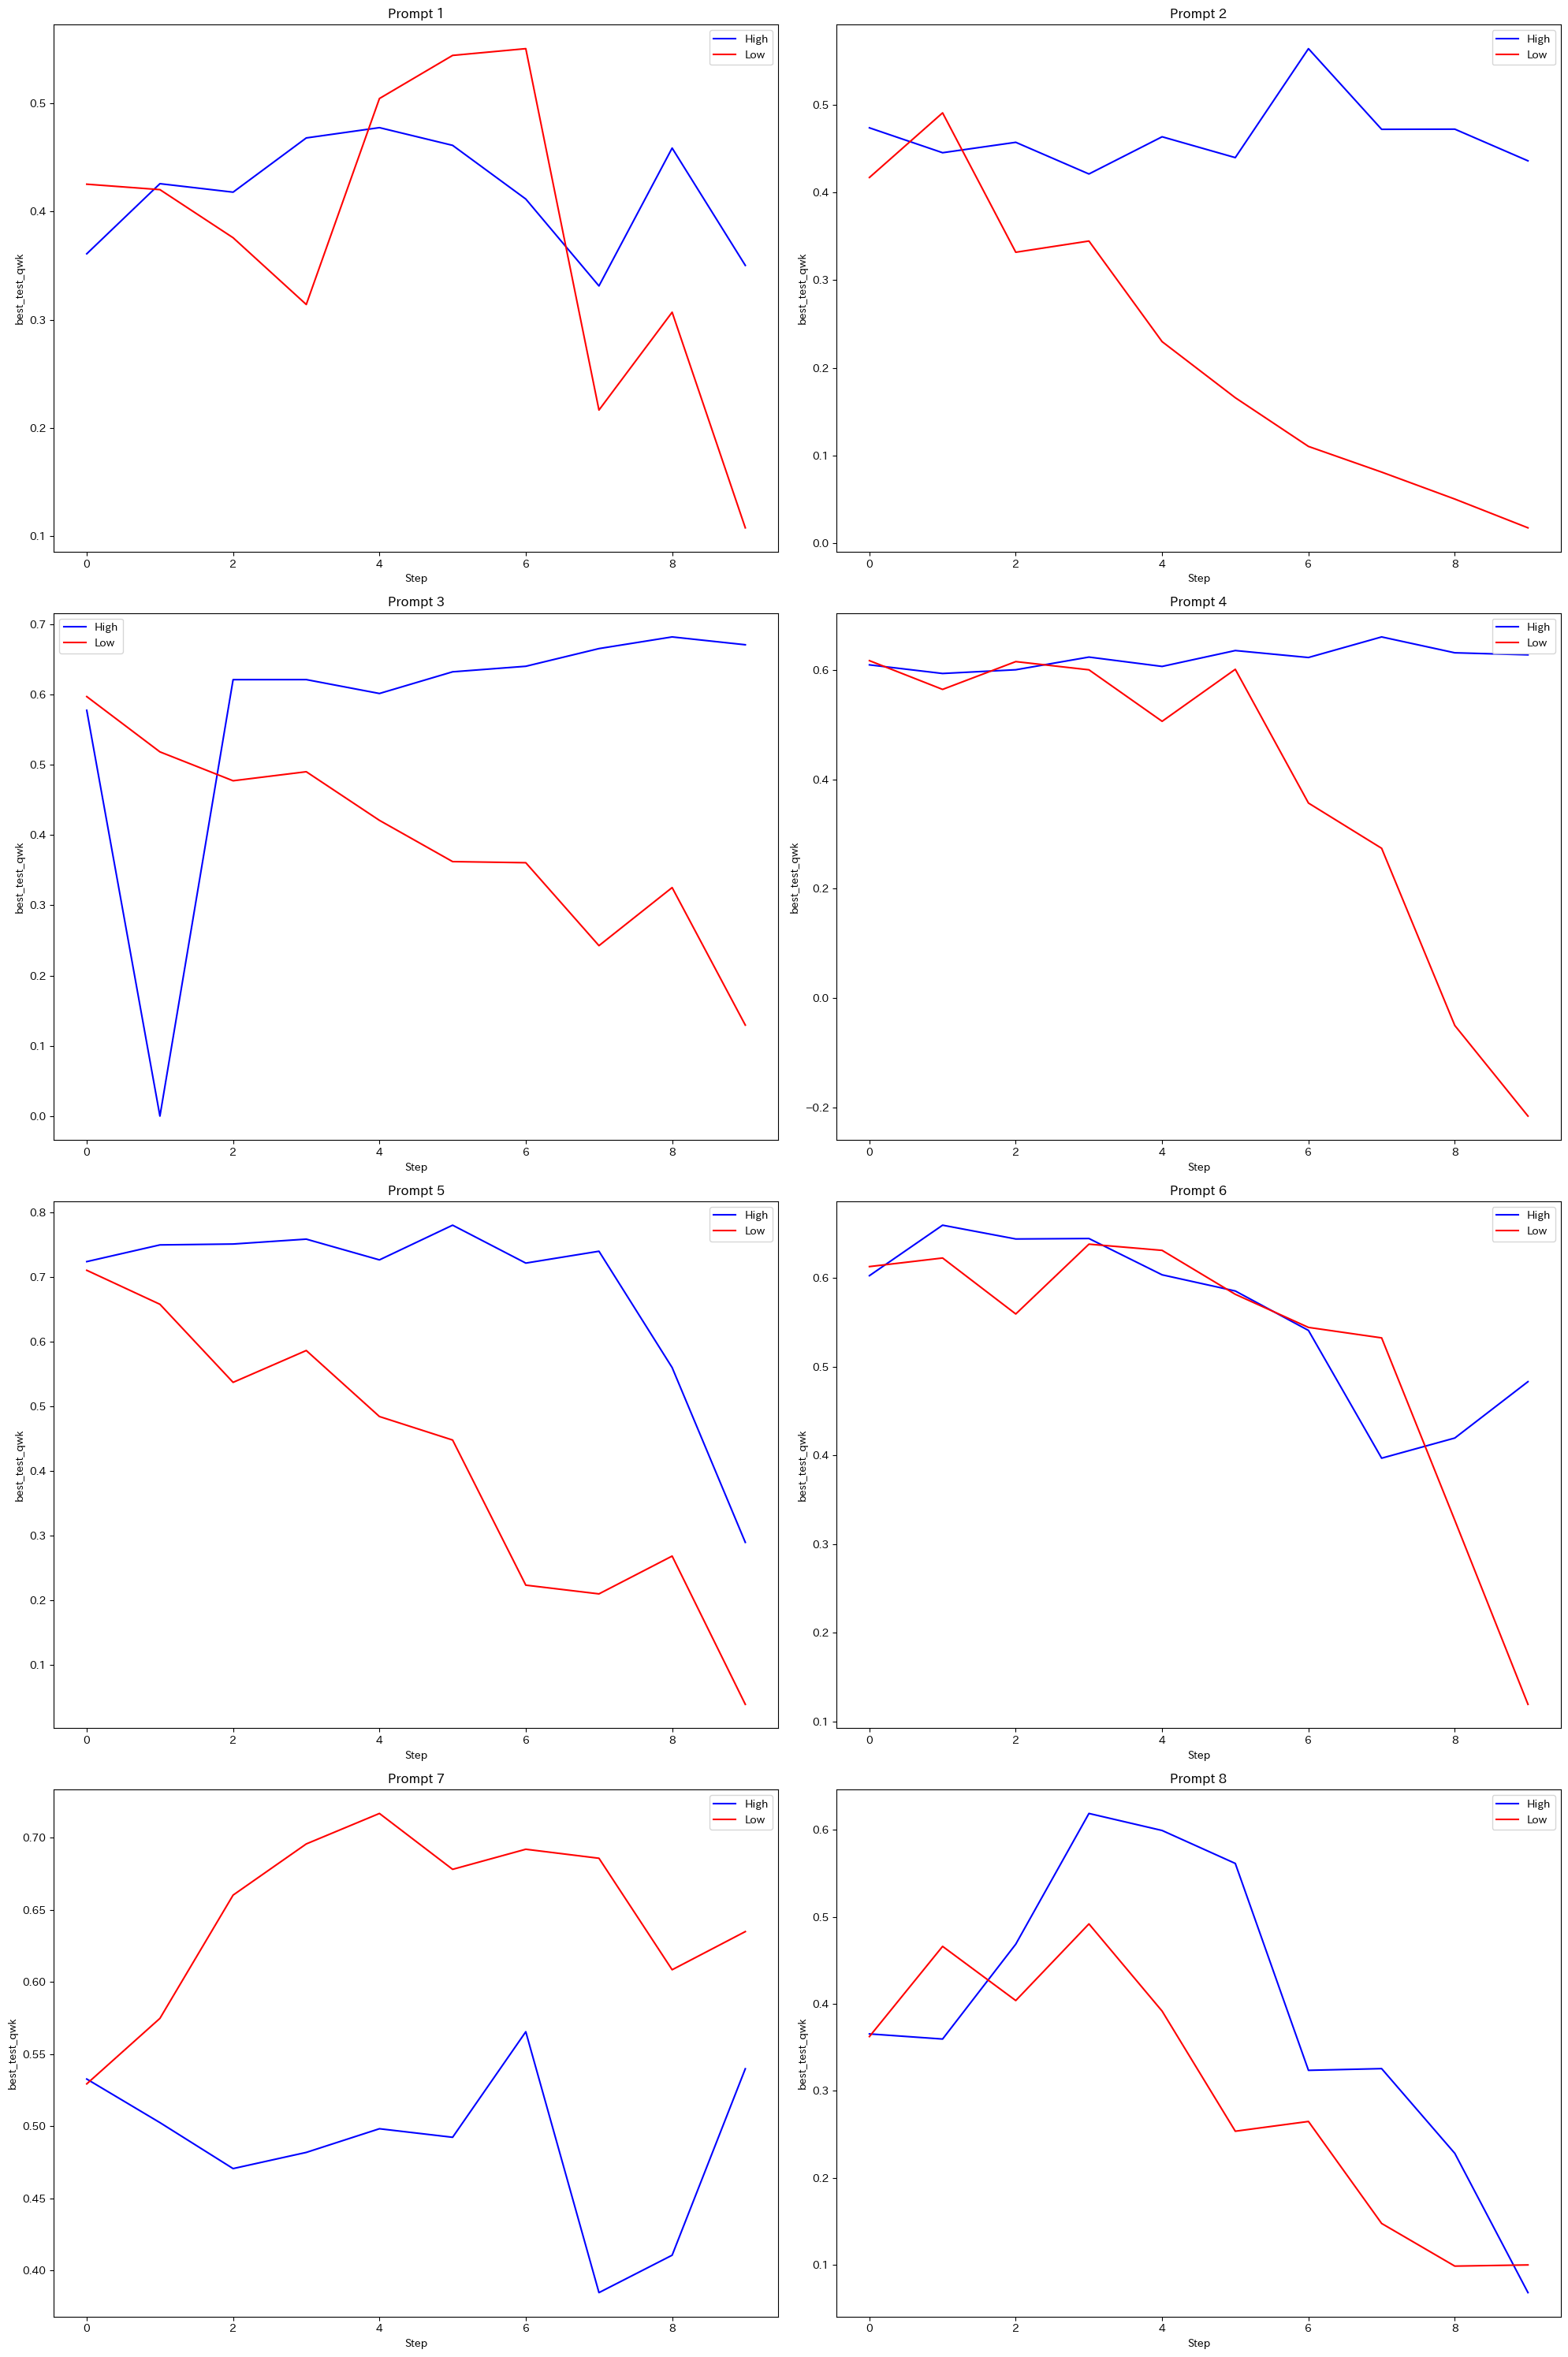

In [238]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(20, 30))

for target_prompt in range(1, 9):
    row = (target_prompt - 1) // 2
    col = (target_prompt - 1) % 2
    
    # Plot for high
    axs[row, col].plot(df_high['Step'], df_high[df_high.columns[target_prompt]], label='High', color='blue')
    
    # Plot for low
    axs[row, col].plot(df_low['Step'], df_low[df_low.columns[target_prompt]], label='Low', color='red')
    
    axs[row, col].set_title(f'Prompt {target_prompt}')
    axs[row, col].set_xlabel('Step')
    axs[row, col].set_ylabel('best_test_qwk')
    axs[row, col].legend()

plt.tight_layout()
plt.show()